In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from IPython.display import display, Markdown
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

# Set display options to show first and last 5 rows
pd.set_option('display.max_rows', 10)  # This will show 5 rows at the start and 5 at the end
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Import utils with different aliases
from src.utils import csv_exporter as csv_utils
from src.utils import validation as val_utils
from src.utils import transformations as trans_utils
from src.utils import data_merger as merge_utils
from src.utils import config_validator as config_utils
from src.utils import metrics as metric_utils
from src.core.bloomberg_fetcher import fetch_bloomberg_data
from src.utils.transformations import get_ohlc

In [12]:
# Getting all the data 
mapping = {
    ('I05510CA Index', 'INDEX_OAS_TSY_BP'): 'cad_oas',
    ('LF98TRUU Index', 'INDEX_OAS_TSY_BP'): 'us_hy_oas',
    ('LUACTRUU Index', 'INDEX_OAS_TSY_BP'): 'us_ig_oas',
    ('SPTSX Index', 'PX_LAST'): 'tsx',
    ('VIX Index', 'PX_LAST'): 'vix',
    ('USYC3M30 Index', 'PX_LAST'): 'us_3m_10y',
    ('BCMPUSGR Index', 'PX_LAST'): 'us_growth_surprises',
    ('BCMPUSIF Index', 'PX_LAST'): 'us_inflation_surprises',
    ('LEI YOY  Index', 'PX_LAST'): 'us_lei_yoy',
    ('.HARDATA G Index', 'PX_LAST'): 'us_hard_data_surprises',
    ('CGERGLOB Index', 'PX_LAST'): 'us_equity_revisions',
    ('.ECONREGI G Index', 'PX_LAST'): 'us_economic_regime',
 
}

# Calculate dates
end_date = datetime.now().strftime('%Y-%m-%d')
start_date ='2002-01-01'

# Fetch the data
df = fetch_bloomberg_data(
    mapping=mapping,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
)

print(df.info())
print('-------')
print('-------')
print(df.head())
print('-------')
print('-------')
print(df.tail())
print('-------')
print('-------')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 342 entries, 2002-10-31 to 2024-11-30
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cad_oas                 342 non-null    float64
 1   us_hy_oas               342 non-null    float64
 2   us_ig_oas               342 non-null    float64
 3   tsx                     342 non-null    float64
 4   vix                     342 non-null    float64
 5   us_3m_10y               342 non-null    float64
 6   us_growth_surprises     342 non-null    float64
 7   us_inflation_surprises  342 non-null    float64
 8   us_lei_yoy              342 non-null    float64
 9   us_hard_data_surprises  342 non-null    float64
 10  us_equity_revisions     342 non-null    float64
 11  us_economic_regime      342 non-null    float64
dtypes: float64(12)
memory usage: 34.7 KB
None
-------
-------
              cad_oas    us_hy_oas   us_ig_oas      tsx    vix  us_3m_1

In [13]:
# Viz to make sure all the data looks ok



def create_spread_plots(df):
    # Calculate number of rows and columns needed based on number of series
    n_series = len(df.columns)
    n_rows = math.ceil(n_series / 3)  # Calculate required rows
    n_cols = min(3, n_series)  # Use 3 columns or less if fewer series
    
    # Adjust vertical spacing based on number of rows
    vertical_spacing = min(0.08, 1.0 / (n_rows + 1))  # Dynamic spacing
    
    # Create subplot grid
    fig = make_subplots(
        rows=n_rows, 
        cols=n_cols,
        subplot_titles=df.columns,
        vertical_spacing=vertical_spacing,
        horizontal_spacing=0.05
    )
    
    # Add each series to a subplot
    for idx, column in enumerate(df.columns):
        row = (idx // n_cols) + 1
        col = (idx % n_cols) + 1
        
        fig.add_trace(
            go.Scatter(
                x=df.index,
                y=df[column],
                name=column,
                line=dict(width=1),
                showlegend=False,
                hovertemplate=
                "<b>%{x}</b><br>" +
                "Value: %{y:.2f}<br>" +
                "<extra></extra>"
            ),
            row=row,
            col=col
        )
        
        # Update axes labels
        fig.update_xaxes(
            title_text="Date",
            row=row,
            col=col,
            showgrid=True,
            gridcolor='rgba(128, 128, 128, 0.2)',
            tickangle=45,
            tickformat='%Y-%m-%d'
        )
        fig.update_yaxes(
            title_text="Spread",
            row=row,
            col=col,
            showgrid=True,
            gridcolor='rgba(128, 128, 128, 0.2)'
        )

    # Update layout for dark theme and responsiveness
    fig.update_layout(
        template='plotly_dark',
        showlegend=False,
        height=250 * n_rows,  # Adjusted height per row
        title={
            'text': 'Spread Series Over Time',
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        paper_bgcolor='rgb(30, 30, 30)',
        plot_bgcolor='rgb(30, 30, 30)',
        margin=dict(t=80, l=50, r=50, b=50),
        font=dict(
            family="Arial",
            size=10,
            color="white"
        )
    )

    # Make it responsive
    fig.update_layout(
        autosize=True,
    )
    
    # Show the plot
    fig.show(config={
        'responsive': True,
        'displayModeBar': True,
        'scrollZoom': True,
        'modeBarButtonsToAdd': ['drawline', 'drawopenpath', 'eraseshape']  # Add drawing tools
    })

# Create the plots
create_spread_plots(df)

In [14]:

# Calculate the 1, 3, and 6 period percentage change for the 'tsx' column

df['tsx_1_period_change'] = df['tsx'].pct_change(periods=1) * 100
df['tsx_3_period_change'] = df['tsx'].pct_change(periods=3) * 100
df['tsx_6_period_change'] = df['tsx'].pct_change(periods=6) * 100

# Drop the original 'tsx' column
df.drop(columns=['tsx'], inplace=True)
# Remove rows with any NaN values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 2003-03-31 to 2024-11-30
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cad_oas                 336 non-null    float64
 1   us_hy_oas               336 non-null    float64
 2   us_ig_oas               336 non-null    float64
 3   vix                     336 non-null    float64
 4   us_3m_10y               336 non-null    float64
 5   us_growth_surprises     336 non-null    float64
 6   us_inflation_surprises  336 non-null    float64
 7   us_lei_yoy              336 non-null    float64
 8   us_hard_data_surprises  336 non-null    float64
 9   us_equity_revisions     336 non-null    float64
 10  us_economic_regime      336 non-null    float64
 11  tsx_1_period_change     336 non-null    float64
 12  tsx_3_period_change     336 non-null    float64
 13  tsx_6_period_change     336 non-null    float64
dtypes: float64(14)
memory u

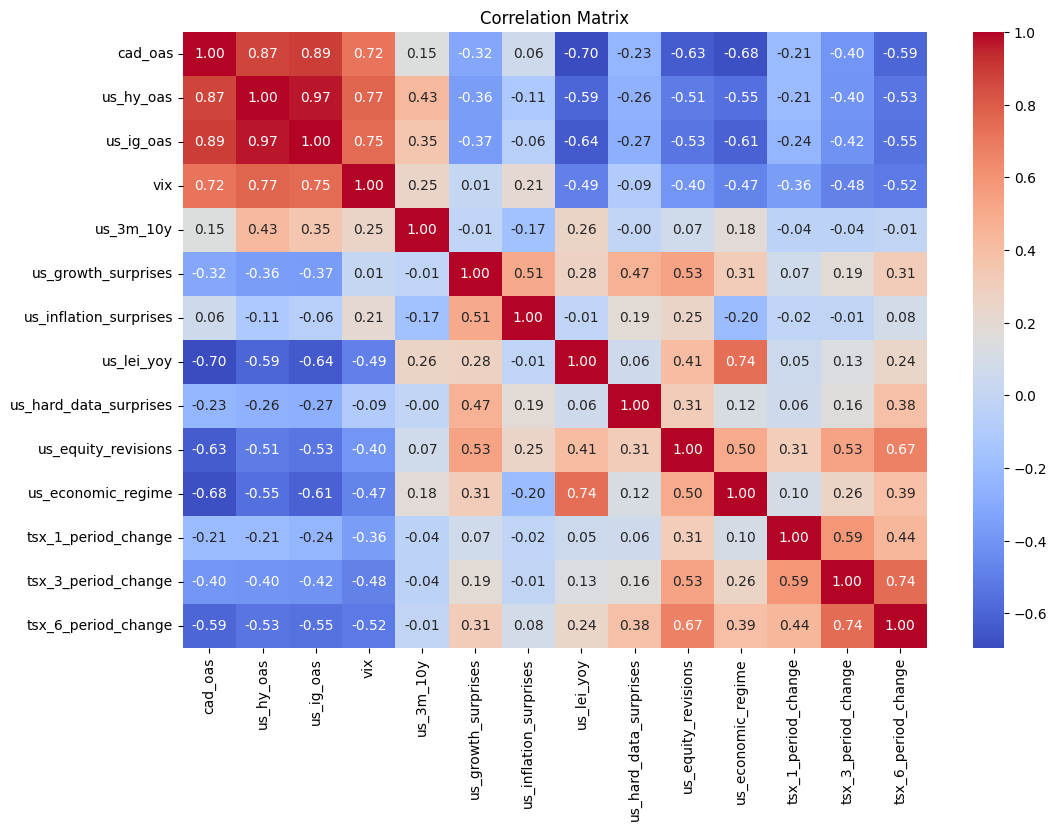


Variance Inflation Factor (VIF):
                Feature        VIF
0                 const  48.734186
1             us_hy_oas  27.423696
2             us_ig_oas  22.648894
3                   vix   4.508362
4             us_3m_10y   3.462211
..                  ...        ...
9   us_equity_revisions   2.759234
10   us_economic_regime   3.386188
11  tsx_1_period_change   1.642645
12  tsx_3_period_change   2.978236
13  tsx_6_period_change   3.840431

[14 rows x 2 columns]


<Figure size 1500x2000 with 0 Axes>

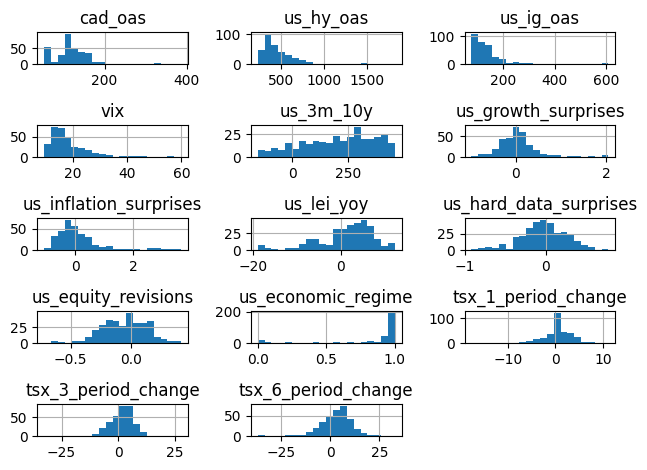

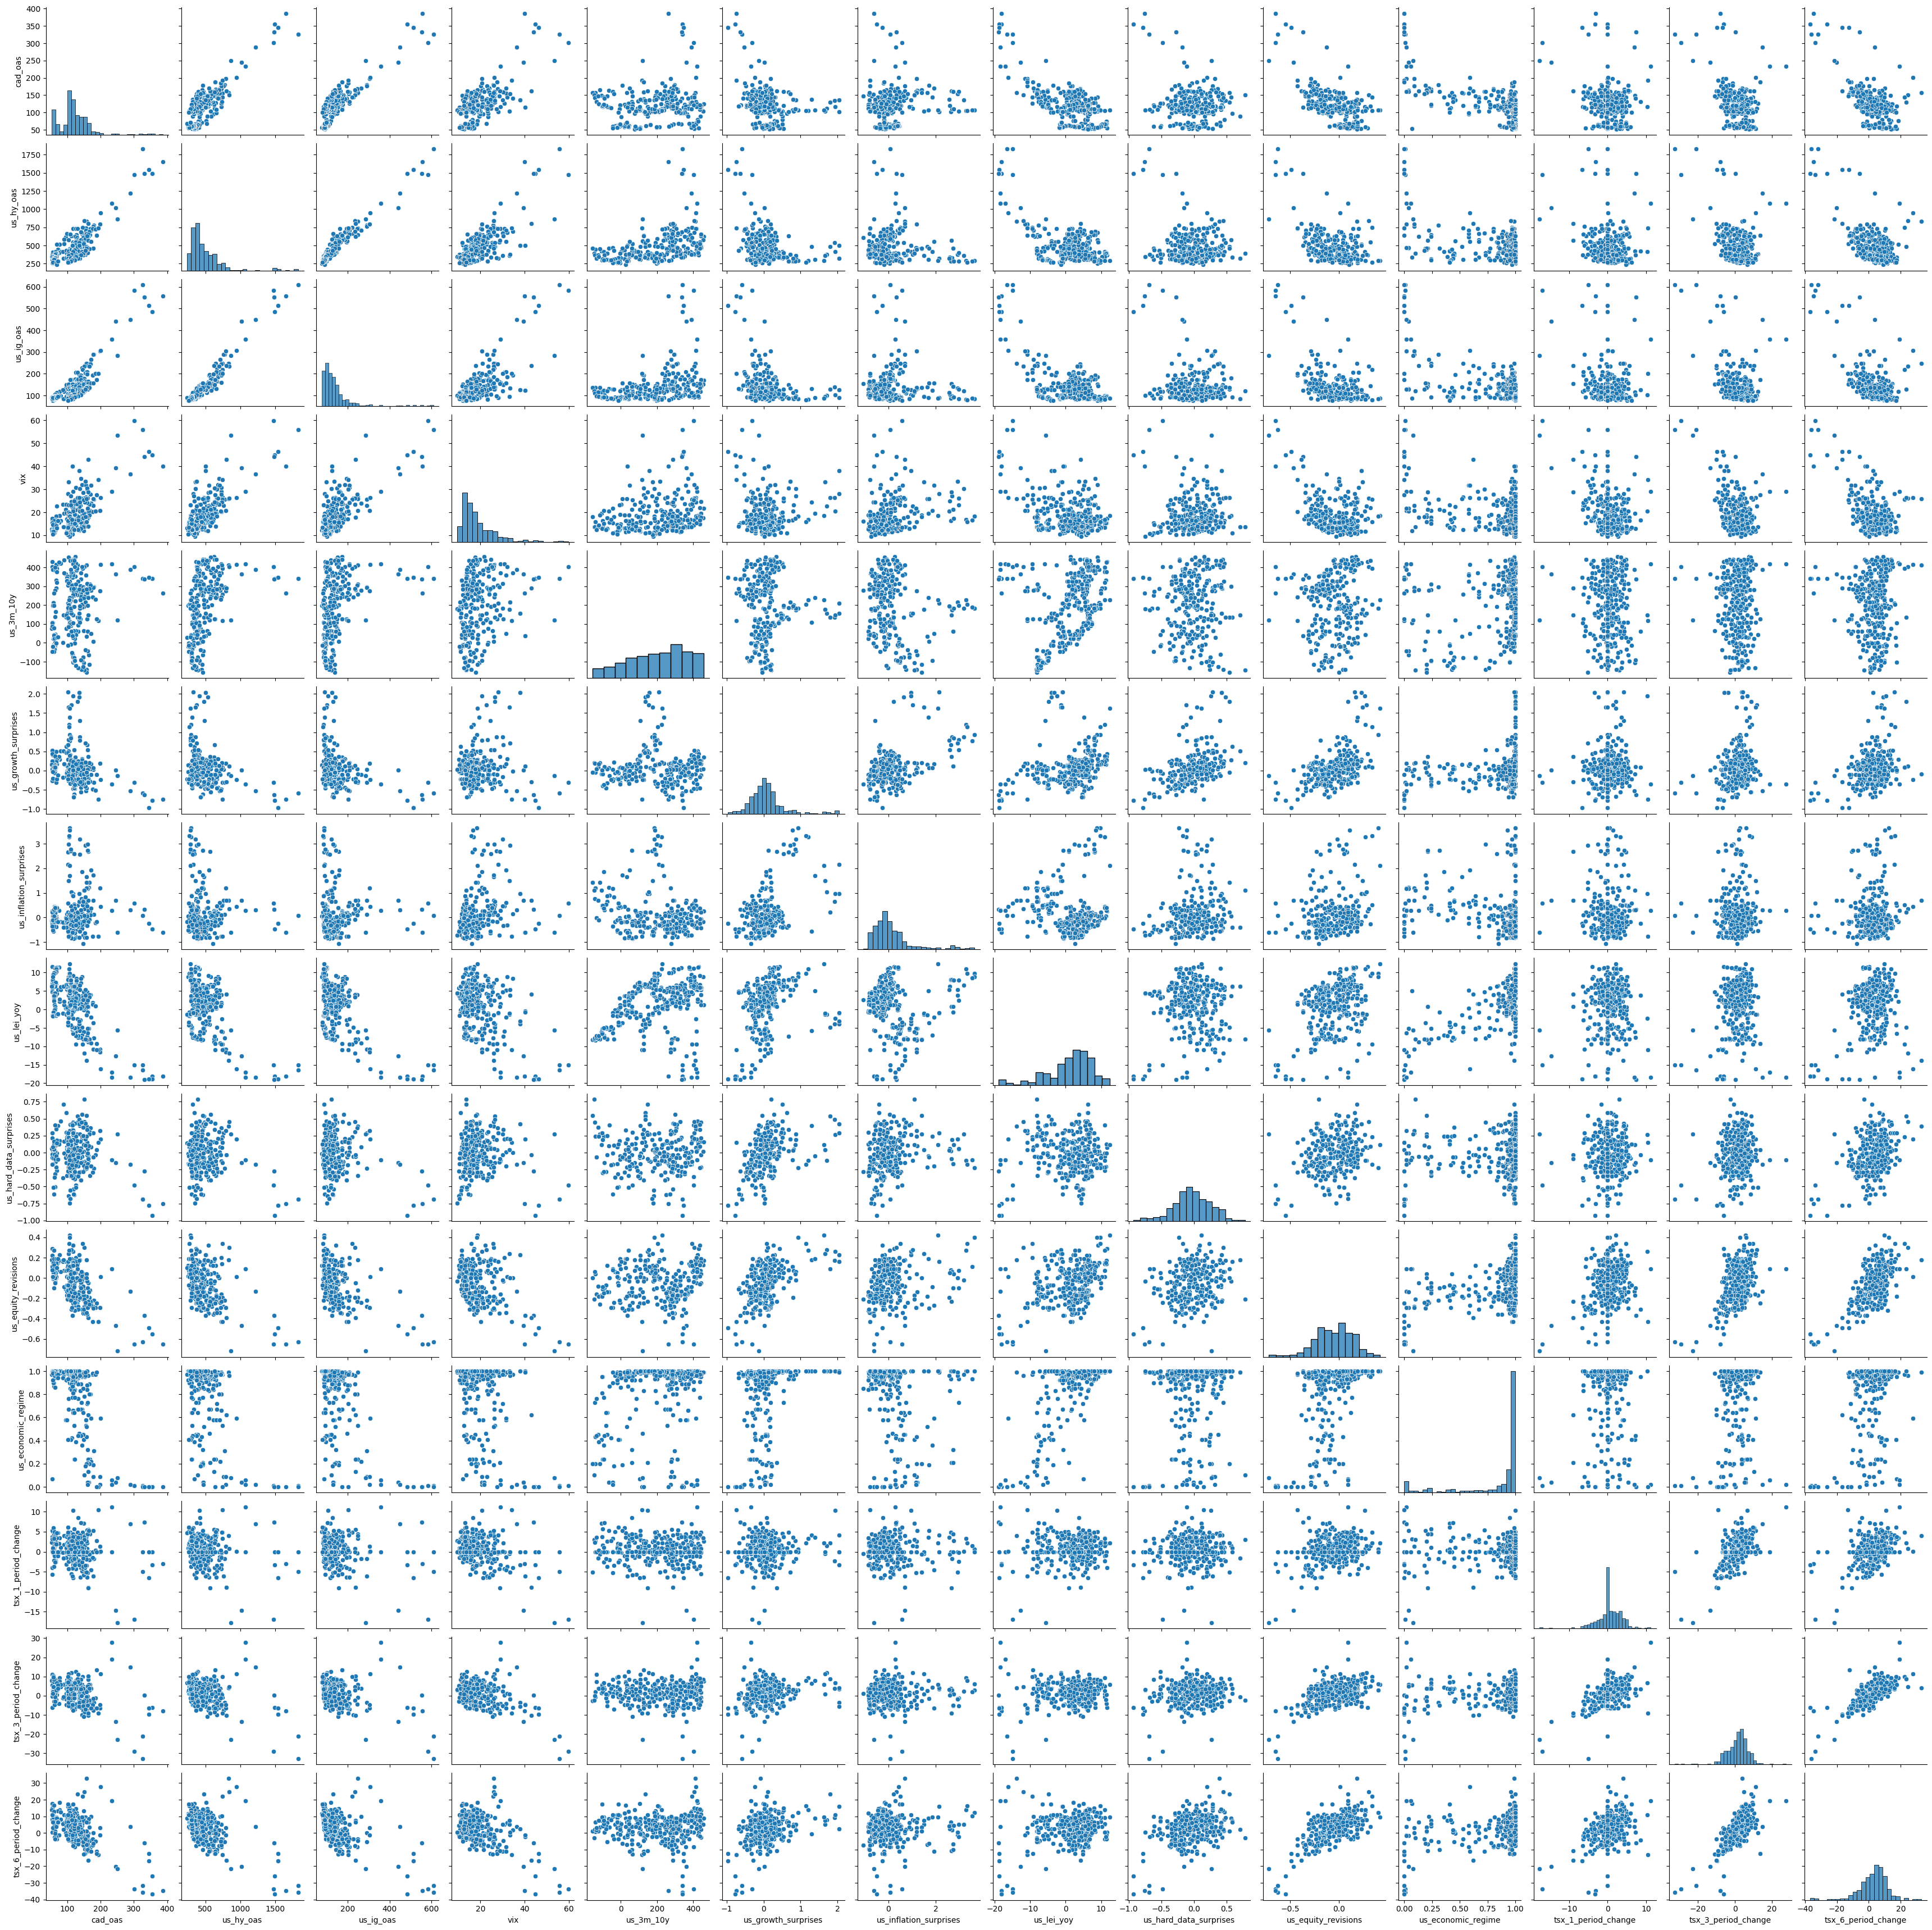

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Multicollinearity Check using VIF
X = df.drop(columns=['cad_oas'])
X = sm.add_constant(X)  # Adding a constant for VIF calculation
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVariance Inflation Factor (VIF):")
print(vif_data)

# Distribution Analysis: Plotting distributions of all features
n_cols = len(df.columns)
n_rows = (n_cols + 2) // 3  # Calculate needed rows for 3 columns
plt.figure(figsize=(15, n_rows * 4))
df.hist(bins=20, layout=(n_rows, 3))
plt.tight_layout()
plt.show()

# Advanced Visualizations: Pair Plot
sns.pairplot(df)
plt.show()

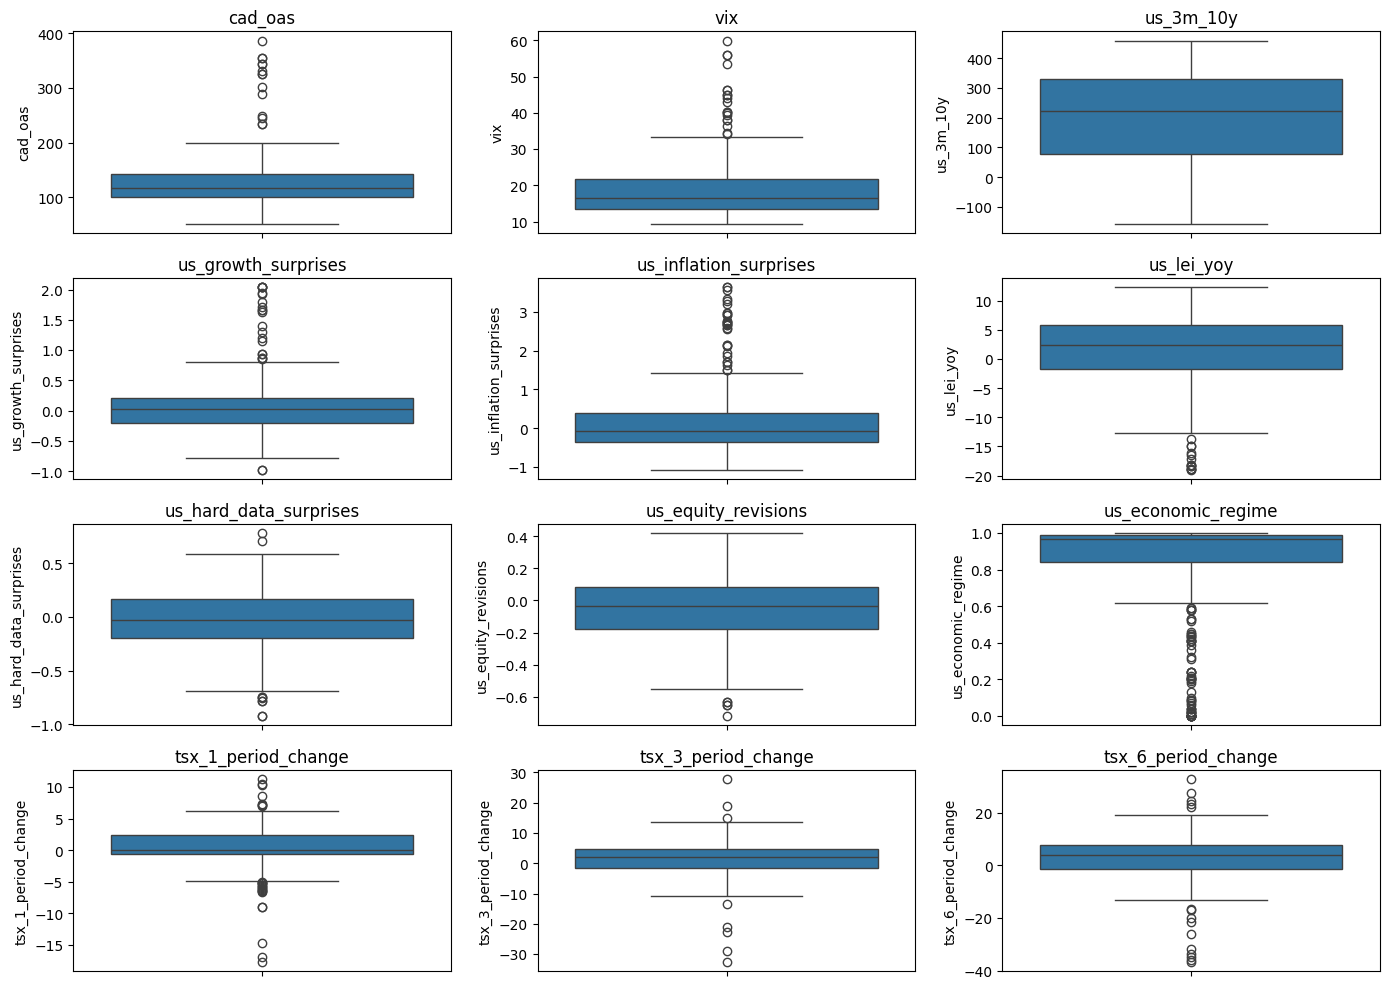

In [19]:

# Here, we will remove 'us_hy_oas' and 'us_ig_oas' due to their high VIF values
reduced_df = df.drop(columns=['us_hy_oas', 'us_ig_oas'])

# Box plots for each feature in the reduced dataset
plt.figure(figsize=(14, 10))
for i, column in enumerate(reduced_df.columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=reduced_df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [21]:
# Define a function to create new features for non-target columns
def create_features(df, target_column):
    for column in df.columns:
        if column != target_column:
            # 1. Rolling Mean (3-month)
            df[f'{column}_rolling_mean_3m'] = df[column].rolling(window=3).mean()
            
            # 2. Rolling Standard Deviation (3-month)
            df[f'{column}_rolling_std_3m'] = df[column].rolling(window=3).std()
            
            # 3. Exponential Moving Average (6-month)
            df[f'{column}_ema_6m'] = df[column].ewm(span=6, adjust=False).mean()
            
            # 4. Lag Features (1-month)
            df[f'{column}_lag_1m'] = df[column].shift(1)
            
            # 5. Lag Features (3-month)
            df[f'{column}_lag_3m'] = df[column].shift(3)
            
            # 6. Percentage Change (1-month)
            df[f'{column}_pct_change_1m'] = df[column].pct_change(1)
            
            # 7. Cumulative Sum
            df[f'{column}_cumsum'] = df[column].cumsum()
            
            # 8. Z-Score Normalization
            df[f'{column}_zscore'] = (df[column] - df[column].mean()) / df[column].std()
            
            # 9. Relative Strength Index (RSI)
            # RSI calculation
            window_length = 14
            delta = df[column].diff()
            up, down = delta.copy(), delta.copy()
            up[up < 0] = 0
            down[down > 0] = 0
            roll_up = up.rolling(window_length).mean()
            roll_down = down.abs().rolling(window_length).mean()
            rs = roll_up / roll_down
            df[f'{column}_rsi'] = 100.0 - (100.0 / (1.0 + rs))
            
            # 10. Volatility Index (VIX) Lagged Features
            if column == 'vix':
                df[f'{column}_lag_1m'] = df[column].shift(1)
                df[f'{column}_lag_3m'] = df[column].shift(3)
            
            # 11. Economic Regime Shifts
            if column == 'us_economic_regime':
                df['economic_regime_shift'] = df[column].diff().fillna(0)
            
            # 12. Surprise Indices Interaction Terms
            if column in ['us_growth_surprises', 'us_inflation_surprises']:
                df['growth_inflation_interaction'] = df['us_growth_surprises'] * df['us_inflation_surprises']
            
            # 13. Lead-Lag Relationships
            df[f'{column}_lead_1m'] = df[column].shift(-1)
            
            # 14. Trend Strength Indicator
            df[f'{column}_trend_strength'] = df[f'{column}_ema_6m'] - df[f'{column}_rolling_mean_3m']
            
            # 15. Momentum Indicators
            df[f'{column}_momentum'] = df[column] - df[f'{column}_lag_1m']
            
            # 16. Feature Clustering
            # For simplicity, let's create a cluster feature based on a simple threshold
            # This is a placeholder for more complex clustering techniques
            df[f'{column}_feature_cluster'] = np.where(df[column] > df[column].mean(), 1, 0)

# Apply the function to the dataframe
create_features(df, 'cad_oas')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 2003-03-31 to 2024-11-30
Columns: 418 entries, cad_oas to feature_cluster_feature_cluster
dtypes: float64(386), int32(32)
memory usage: 1.0 MB


In [22]:
df.columns

Index(['cad_oas', 'us_hy_oas', 'us_ig_oas', 'vix', 'us_3m_10y',
       'us_growth_surprises', 'us_inflation_surprises', 'us_lei_yoy',
       'us_hard_data_surprises', 'us_equity_revisions',
       ...
       'feature_cluster_lag_1m', 'feature_cluster_lag_3m',
       'feature_cluster_pct_change_1m', 'feature_cluster_cumsum',
       'feature_cluster_zscore', 'feature_cluster_rsi',
       'feature_cluster_lead_1m', 'feature_cluster_trend_strength',
       'feature_cluster_momentum', 'feature_cluster_feature_cluster'],
      dtype='object', length=418)

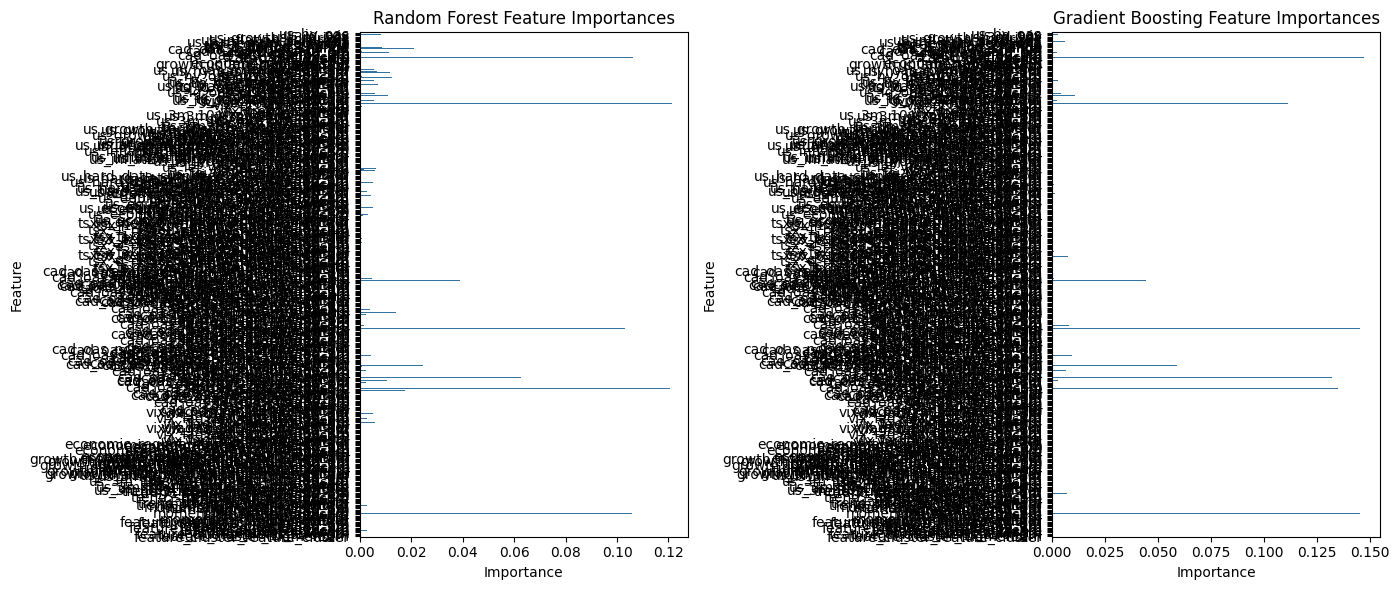

(8.65192410954379, 11.76391246132021)

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is the DataFrame and 'cad_oas' is the target column
# Prepare the data
X = df.drop(columns=['cad_oas'])
y = df['cad_oas']

# Check for infinite values in the dataset
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the models
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)

# Feature importance
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

# Plot feature importances
features = X.columns

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=rf_importances, y=features)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
sns.barplot(x=gb_importances, y=features)
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

rf_mse, gb_mse

In [25]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Select important features for modeling
important_features = ['vix', 'us_hy_oas', 'us_ig_oas', 'us_3m_10y', 'us_economic_regime']
X_important = df[important_features]
y = df['cad_oas']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Initialize models that do not require feature scaling
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict and evaluate
dt_predictions = dt_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)

(dt_mse, rf_mse)

(567.9204883204546, 136.36411052477573)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Define parameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
rf_grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = rf_grid_search.best_estimator_
best_params = rf_grid_search.best_params_

# Predict and evaluate with the best model
train_predictions = best_rf_model.predict(X_train)
test_predictions = best_rf_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

(best_params, train_mse, test_mse, train_r2, test_r2)

({'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 24.66683449392408,
 126.85615607092883,
 0.9907648179290263,
 0.9515626276469528)

In [28]:
import plotly.graph_objects as go
import plotly.express as px

# Create a DataFrame for predictions
predictions_df = X_test.copy()
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = test_predictions

# Sort by index for time series plotting
predictions_df.sort_index(inplace=True)

# 1. Actual vs Predicted Over Time
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Actual'], mode='lines+markers', name='Actual'))
fig1.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicted'], mode='lines+markers', name='Predicted'))
fig1.update_layout(title='Actual vs Predicted CAD OAS Over Time', xaxis_title='Date', yaxis_title='CAD OAS')

# 2. Residuals Over Time
residuals = predictions_df['Actual'] - predictions_df['Predicted']
fig2 = px.scatter(x=predictions_df.index, y=residuals, title='Residuals Over Time', labels={'x': 'Date', 'y': 'Residuals'})

# 3. Feature Importances
importances = best_rf_model.feature_importances_
fig3 = px.bar(x=important_features, y=importances, title='Feature Importances', labels={'x': 'Feature', 'y': 'Importance'})

# 4. Actual vs Predicted Scatter Plot
fig4 = px.scatter(x=predictions_df['Actual'], y=predictions_df['Predicted'], title='Actual vs Predicted Scatter Plot', labels={'x': 'Actual CAD OAS', 'y': 'Predicted CAD OAS'})
fig4.add_shape(type='line', x0=predictions_df['Actual'].min(), y0=predictions_df['Actual'].min(), x1=predictions_df['Actual'].max(), y1=predictions_df['Actual'].max(), line=dict(color='Red',), xref='x', yref='y')

# 5. Distribution of Residuals
fig5 = px.histogram(residuals, nbins=30, title='Distribution of Residuals', labels={'value': 'Residuals'})

# 6. Cumulative Actual vs Predicted
cumulative_actual = predictions_df['Actual'].cumsum()
cumulative_predicted = predictions_df['Predicted'].cumsum()
fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=predictions_df.index, y=cumulative_actual, mode='lines', name='Cumulative Actual'))
fig6.add_trace(go.Scatter(x=predictions_df.index, y=cumulative_predicted, mode='lines', name='Cumulative Predicted'))
fig6.update_layout(title='Cumulative Actual vs Predicted CAD OAS', xaxis_title='Date', yaxis_title='Cumulative CAD OAS')

# Display the figures
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()